In [ ]:
## Importing Libraries
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [50]:
## Defining RBF Kernel
def rbf(t1, t2, l, sigma_f):
    t1 = t1.reshape(-1, 1)
    t2 = t2.reshape(1, -1)
    return sigma_f * np.exp(-((t1 - t2) ** 2) / (2.0 * l**2))

## Covariance Matrix
def Generate_K_theta(t, hyper_params = [1.5, 1.8, 0.2]):
    l, sigma_f, sigma_w = hyper_params
    K_f = rbf(t, t, l, sigma_f)
    K_theta = K_f + sigma_w * np.eye(len(t))
    return K_theta, K_f

In [51]:
def log_likelihood(t, Y, hyper_params):
    K_theta, K_f = Generate_K_theta(t, hyper_params)
    X = np.linalg.solve(K_theta, Y)  # K_theta X = Y

    sign, logdet = np.linalg.slogdet(K_theta)
    if sign <= 0:
        # safety just in case
        logdet = np.log(np.abs(np.linalg.det(K_theta)) + 1e-12)

    objective_fn = -0.5 * (Y @ X) - 0.5 * logdet - 0.5 * len(t) * np.log(2 * np.pi)
    return objective_fn



def gradient_log_likelihood(t, Y, hyper_params):
  K_theta, K_f = Generate_K_theta(t, hyper_params)
  l, sigma_f, sigma_w = hyper_params
  X = np.linalg.solve(K_theta, Y) # considering KX = Y
  K_inv = np.linalg.inv(K_theta)

  # dk_theta/ dsigma_f
  dk_dsigma_f = K_f /sigma_f

  # dk_theta/ dl
  t_i = t.reshape(-1, 1)
  t_j = t.reshape(1, -1)
  dk_dl = K_f * ((t_i - t_j) ** 2) / (l**3)

  # dk_theta/ dsigma_w
  dk_dsigma_w = np.eye(len(t))

  ## Calculating Gradient
  grad_sigma_f = (0.5 * (X @ (dk_dsigma_f @ X))) - (0.5 * np.trace(K_inv @ dk_dsigma_f))
  grad_l = (0.5 * (X @ (dk_dl @ X))) - (0.5 * np.trace(K_inv @ dk_dl))
  grad_sigma_w = (0.5 * (X @ (dk_dsigma_w @ X))) - (0.5 * np.trace(K_inv @ dk_dsigma_w))

  return np.array([grad_l, grad_sigma_f, grad_sigma_w])



In [52]:
def optimize_theta(t, Y, theta_init, lr=1e-3, max_iter=200,earlyStopping=True, tol=1e-3, verbose = True):
    # log-space so parameters stay positive
    phi = np.log(theta_init)

    objective_prev = -np.inf
    for k in range(max_iter):
        theta = np.exp(phi)

        # objective and gradient w.r.t. theta
        objective_fn = log_likelihood(t, Y, theta)
        grad_theta   = gradient_log_likelihood(t, Y, theta)

        # gradient in log-space: dL/dphi_i = theta_i * dL/dtheta_i
        grad_phi = theta * grad_theta
        phi += lr * grad_phi  # gradient ascent

        if verbose:
          if k % 20 == 0 or k == max_iter - 1:
              print(f"iter {k:3d}, L = {objective_fn:.4f}, theta = {theta}")

        if earlyStopping and k > 0:
            if abs(objective_fn - objective_prev) < tol:
                if verbose:
                  print(f"Early stopping at iter {k}, ΔL = {objective_fn - objective_prev:.4e}")
                break

        objective_prev = objective_fn

    return np.exp(phi)


In [47]:
# def posterior_gp(t_train, Y_train, t_star, theta):
#   l, sigma_f, sigma_w = theta
#   K_theta_train, _ = Generate_K_theta(t_train, theta)
#   K_inv = np.linalg.inv(K_theta_train)

#   #cross covariance
#   K_star = rbf(t_train, t_star, l, sigma_f)

#   #variance on test input
#   test_var = rbf(t_star, t_star, l, sigma_f)
#   test_var_diag = np.diag(test_var)

#   # Posterior mean: m_* = K_*^T K^{-1} Y
#   m_star = K_star.T @ (K_inv @ Y_train)

#   # Posterior variance: sigma_*^2 = k_ss - diag(K_*^T K^{-1} K_*)
#   cov_term = K_star.T @ (K_inv @ K_star)
#   sigma_star = test_var_diag - np.diag(cov_term)

#   return m_star, sigma_star


In [53]:
def posterior_gp(t_train, Y_train, t_star, theta):

    l, sigma_f, sigma_w = theta
    K_train, _ = Generate_K_theta(t_train, theta)
    K_inv = np.linalg.inv(K_train)

    # Cross-covariance between training and test points:
    K_star = rbf(t_train, t_star, l, sigma_f)

    # Prior covariance at test points: (N, N)
    K_test_points = rbf(t_star, t_star, l, sigma_f)

    # Posterior mean: m_* = K_*^T K_train^{-1} Y   → (N,)
    m_star = K_star.T @ (K_inv @ Y_train)

    # Posterior covariance: Σ_* = K_ss - K_*^T K_train^{-1} K_*
    cov_matrix = K_test_points - K_star.T @ (K_inv @ K_star)

    # Diagonal (posterior variances) : (N,)
    sigma_star = np.diag(cov_matrix)

    return m_star, sigma_star, cov_matrix


In [67]:
## Loading data
data = scipy.io.loadmat('/content/GP_RegressionProject.mat')
t = data['t'].reshape(-1)
Y = data['y'].reshape(-1)

rng = np.random.default_rng(0)
n = 50
idx_train = rng.choice(len(t), size=n, replace=False)
idx_train.sort()
t_train = t[idx_train]
Y_train = Y[idx_train]


## Objective 1
Choose $n = 50$ training samples randomly from the 200-sized grid. Given the function data of the 50 samples (attached to the project announcement), model a Gaussian process regression to estimate the remaining samples over the 200 time indexes in $t \in [-2,2]$. Plot the posterior mean estimate over the full domain $t \in [-2,2]$.

In [54]:
theta_init = np.array([0.5, 1.0, 0.1])  # initial values of hyperparameters.
theta_star = optimize_theta(t_train, Y_train, theta_init,
                            lr=5e-3, max_iter=500, earlyStopping=True, tol = 0.001)
print("Optimized theta* =", theta_star)

optimized_theta = theta_star

iter   0, L = -48.7547, theta = [0.5 1.  0.1]
iter  20, L = -39.9888, theta = [0.80260212 0.94044628 0.19064281]
iter  40, L = -39.1957, theta = [1.05705737 0.94876173 0.19910254]
iter  60, L = -38.8416, theta = [1.26255777 1.004655   0.19910137]
iter  80, L = -38.7079, theta = [1.36737779 1.08975975 0.19827764]
iter 100, L = -38.6308, theta = [1.41429744 1.18167261 0.19776048]
iter 120, L = -38.5739, theta = [1.445436   1.27027508 0.19745048]
iter 140, L = -38.5305, theta = [1.47104791 1.35354045 0.19722508]
iter 160, L = -38.4971, theta = [1.49328063 1.43130201 0.19704464]
iter 180, L = -38.4711, theta = [1.51286438 1.5037332  0.19689541]
Early stopping at iter 193, ΔL = 9.9103e-04
Optimized theta* = [1.52523508 1.55139465 0.19680556]


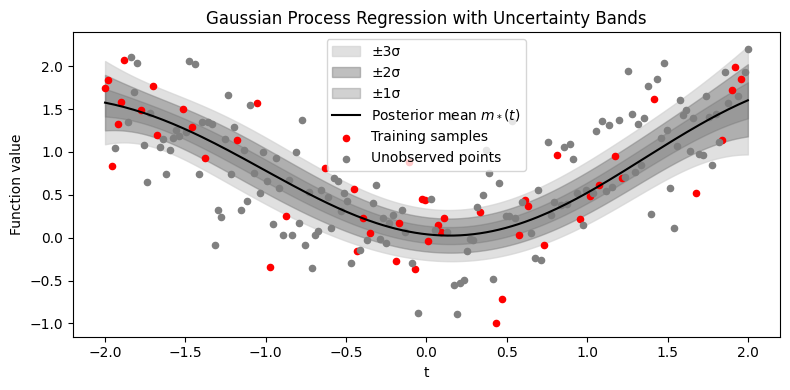

In [56]:
# Posterior mean and variance over full grid
m_star, sigma_star, _ = posterior_gp(t_train, Y_train, t, theta_star)

std = np.sqrt(sigma_star)

plt.figure(figsize=(8, 4))

# 3σ band – lightest gray
plt.fill_between(
    t,
    m_star - 3 * std,
    m_star + 3 * std,
    color="lightgray",
    alpha=0.7,
    label="±3σ"
)

# 2σ band – medium gray
plt.fill_between(
    t,
    m_star - 2 * std,
    m_star + 2 * std,
    color="gray",
    alpha=0.5,
    label="±2σ"
)

# 1σ band – darkest gray
plt.fill_between(
    t,
    m_star - 1 * std,
    m_star + 1 * std,
    color="dimgray",
    alpha=0.3,
    label="±1σ"
)

#Mean and data points
plt.plot(t, m_star, label="Posterior mean $m_*(t)$", color="black")

# Training points
plt.scatter(t_train, Y_train, color="red", s=20, label="Training samples")

# Unobserved points
mask_rest = np.ones(len(t), dtype=bool)
mask_rest[idx_train] = False
t_rest = t[mask_rest]
Y_rest = Y[mask_rest]
plt.scatter(t_rest, Y_rest, color="gray", s=20, label="Unobserved points")

plt.xlabel("t")
plt.ylabel("Function value")
plt.title("Gaussian Process Regression with Uncertainty Bands")
plt.legend()
plt.tight_layout()
plt.savefig('posterior_gp.jpg', dpi= 400)
plt.show()


In [57]:
# Saving the train, test and posterior data
is_train = np.zeros(len(t), dtype=bool)
is_train[idx_train] = True

df_gp = pd.DataFrame({
    "t": t,
    "Y": Y,
    "is_train": is_train,
    "m_star": m_star,
    "sigma_star": sigma_star
})

df_gp.to_csv("gp_results_task1.csv", index=False)
df_gp.head()


,t,Y,is_train,m_star,sigma_star
0,-2.000000,1.744262,True,1.574106,0.026148
1,-1.979899,1.840452,True,1.566434,0.024599
2,-1.959799,0.835522,True,1.558330,0.023184
3,-1.939698,1.050626,False,1.549796,0.021896
4,-1.919598,1.320838,True,1.540833,0.020731


### Objective 2
Repeat the estimation procedure for 10 different realizations of different 50 time samples. Compute the empirical average of the error over the 10 different realizations (i.e., compute the squared error of the estimates compared to the true value of the function). Repeat the process for training set sizes of 40, 30, 20, and 10. Compare the average estimation error across the 50, 40, 30, 20, and 10 sized estimation tasks.

In [ ]:
def gp_fit_and_mse(
        t_grid,
        y_obs,
        n_train,
        theta_init = np.array([0.5, 1.0, 0.1]),
        lr=5e-3,
        max_iter=300,
        earlyStopping=True,
        tol=1e-3,
        rng=None,
        verbose = False
):

    if rng is None:
        rng = np.random.default_rng()

    N = len(t_grid)
    idx_train = rng.choice(N, size=n_train, replace=False)
    idx_train.sort()

    t_train = t_grid[idx_train]
    y_train = y_obs[idx_train]

    # optimize hyperparameters
    theta_star = optimize_theta(
        t_train,
        y_train,
        theta_init=theta_init,
        lr=lr,
        max_iter=max_iter,
        earlyStopping=earlyStopping,
        tol=tol,
        verbose=verbose
    )

    # Posterior prediction on the entire grid
    m_star, sigma2_star = posterior_gp(t_train, y_train, t_grid, theta_star)

    # MSE vs the observed function values
    mse = np.mean((m_star - y_obs) ** 2)

    return mse, theta_star, idx_train, m_star, sigma2_star


def run_gpr(
        t_grid,
        y_obs,
        train_sizes=(50, 40, 30, 20, 10),
        n_realizations=10,
        theta_init=np.array([0.5, 1.0, 0.1]),
        lr=5e-3,
        max_iter=300,
        earlyStopping=True,
        tol=1e-3,
        seed=2025,
        verbose = False
):

    rng = np.random.default_rng(seed)

    avg_mse = []

    for n_train in train_sizes:
        mse_list = []
        print(f"Running {n_realizations} realizations for n = {n_train} ...")

        for r in range(n_realizations):
            mse, _, _, _, _ = gp_fit_and_mse(
                t_grid=t_grid,
                y_obs=y_obs,
                n_train=n_train,
                theta_init=theta_init,
                lr=lr,
                max_iter=max_iter,
                earlyStopping=earlyStopping,
                tol=tol,
                rng=rng,
                verbose=verbose
            )
            mse_list.append(mse)

        mean_mse = np.mean(mse_list)
        avg_mse.append(mean_mse)
        print(f"  -> average MSE for n={n_train}: {mean_mse:.4e}")

    return np.array(train_sizes), np.array(avg_mse)


In [ ]:
# running 10 realizations for different number of sample size
train_sizes, avg_mse = run_gpr(
    t_grid=t,
    y_obs=Y,
    train_sizes= np.arange(10, 201, 10),
    n_realizations=10,
    theta_init=np.array([0.5, 1.0, 0.1]),
    lr=5e-3,
    max_iter=300,
    seed=42,
    verbose = False
)

Running 10 realizations for n = 10 ...
  -> average MSE for n=10: 4.3062e-01
Running 10 realizations for n = 20 ...
  -> average MSE for n=20: 3.0450e-01
Running 10 realizations for n = 30 ...
  -> average MSE for n=30: 2.3935e-01
Running 10 realizations for n = 40 ...
  -> average MSE for n=40: 2.2767e-01
Running 10 realizations for n = 50 ...
  -> average MSE for n=50: 2.2348e-01
Running 10 realizations for n = 60 ...
  -> average MSE for n=60: 2.1812e-01
Running 10 realizations for n = 70 ...
  -> average MSE for n=70: 2.1833e-01
Running 10 realizations for n = 80 ...
  -> average MSE for n=80: 2.1630e-01
Running 10 realizations for n = 90 ...
  -> average MSE for n=90: 2.1523e-01
Running 10 realizations for n = 100 ...
  -> average MSE for n=100: 2.1413e-01
Running 10 realizations for n = 110 ...
  -> average MSE for n=110: 2.1463e-01
Running 10 realizations for n = 120 ...
  -> average MSE for n=120: 2.1169e-01
Running 10 realizations for n = 130 ...
  -> average MSE for n=130: 2.

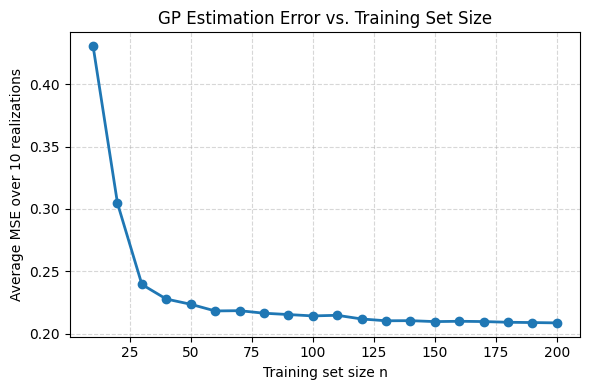

In [ ]:
# Plot: average estimation error vs training set size
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, avg_mse, "o-", linewidth=2)
plt.xlabel("Training set size n")
plt.ylabel("Average MSE over 10 realizations")
plt.title("GP Estimation Error vs. Training Set Size")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig('estimation_error.jpg', dpi= 400)
plt.show()


### Objective 3
Write the full posterior distribution for the 200 time indices, and generate $m$ samples from the posterior. Compute the ensemble average of the samples for $m = 50, 40, 30, 20, 10$, and compare the ensemble average to the posterior mean you computed. Plot the empirical average of the posterior samples you generated. Compute the empirical mean squared error of the posterior samples for each case and plot the empirical MSEs versus the number of posterior samples.

In [58]:
optimized_theta

array([1.52523508, 1.55139465, 0.19680556])

In [73]:
def posterior_sampling(
        t_grid,
        t_train,
        Y_train,
        theta_star,
        m_values=(50, 40, 30, 20, 10),
        seed=2025
):
    m_star, _,  Cov_star = posterior_gp(t_train, Y_train, t_grid, theta_star)

    mse_list = []
    ensemble_means = {}

    for m in m_values:
        # m samples
        rng = np.random.default_rng(seed + m)
        samples = rng.multivariate_normal(mean=m_star, cov=Cov_star, size=m)

        # Ensemble average over samples
        ensemble_mean = samples.mean(axis=0)
        ensemble_means[m] = ensemble_mean

        # Empirical MSE vs posterior mean
        mse = np.mean((ensemble_mean - m_star) ** 2)
        mse_list.append(mse)

        print(f"m = {m:3d}: empirical MSE between ensemble mean and posterior mean = {mse:.4e}")

    return np.array(m_values), np.array(mse_list), m_star, ensemble_means


m =  10: empirical MSE between ensemble mean and posterior mean = 5.6276e-03
m =  20: empirical MSE between ensemble mean and posterior mean = 1.0353e-03
m =  30: empirical MSE between ensemble mean and posterior mean = 6.3734e-04
m =  40: empirical MSE between ensemble mean and posterior mean = 7.0993e-04
m =  50: empirical MSE between ensemble mean and posterior mean = 6.3903e-05
m =  60: empirical MSE between ensemble mean and posterior mean = 1.7475e-04
m =  70: empirical MSE between ensemble mean and posterior mean = 2.7318e-04
m =  80: empirical MSE between ensemble mean and posterior mean = 5.9821e-04
m =  90: empirical MSE between ensemble mean and posterior mean = 2.9744e-04
m = 100: empirical MSE between ensemble mean and posterior mean = 6.1966e-05
m = 110: empirical MSE between ensemble mean and posterior mean = 1.5628e-04
m = 120: empirical MSE between ensemble mean and posterior mean = 1.9502e-04
m = 130: empirical MSE between ensemble mean and posterior mean = 1.9937e-04

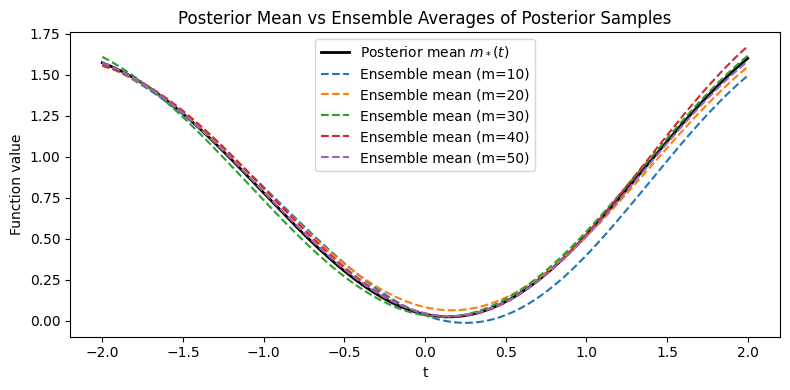

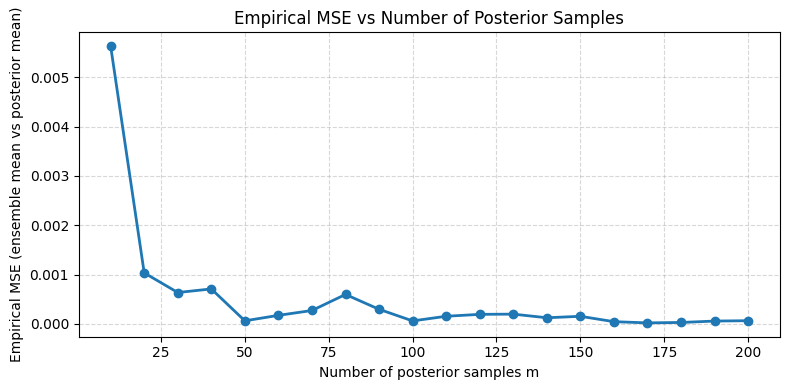

In [78]:
m_values, mse_list, m_star, ensemble_means = posterior_sampling(
        t_grid=t,
        t_train=t_train,
        Y_train=Y_train,
        theta_star=theta_star,
        m_values= np.arange(10, 201, 10),
        seed=123
    )

# Ensemble averages (for each m, we calculate the average of every sample, for every points)
plt.figure(figsize=(8, 4))
plt.plot(t, m_star, "k-", linewidth=2, label="Posterior mean $m_*(t)$")

for m, ens_mean in list(ensemble_means.items())[:5]:
    plt.plot(t, ens_mean, "--", linewidth=1.5, label=f"Ensemble mean (m={m})")

plt.xlabel("t")
plt.ylabel("Function value")
plt.title("Posterior Mean vs Ensemble Averages of Posterior Samples")
plt.legend()
plt.tight_layout()
plt.savefig('posterior_mean_ensemble_means.jpg', dpi= 400)
plt.show()

# Empirical MSE vs the number of posterior samples.
plt.figure(figsize=(8, 4))
plt.plot(m_values, mse_list, "o-", linewidth=2)
plt.xlabel("Number of posterior samples m")
plt.ylabel("Empirical MSE (ensemble mean vs posterior mean)")
plt.title("Empirical MSE vs Number of Posterior Samples")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig('Empirical MSE vs Posterior Samples.jpg')
plt.show()
